# #30DayMapChallenge
## Day 18: Out of this World

### Data Source
1. Mars MGS MOLA - MEX HRSC Blended DEM Global 200m: https://astrogeology.usgs.gov/search/map/mars_mgs_mola_mex_hrsc_blended_dem_global_200m
2. Mercury MESSENGER Global DEM 665m: https://astrogeology.usgs.gov/search/map/mercury_messenger_global_dem_665m
3. Mars/Mercury Features: https://planetarynames.wr.usgs.gov/AdvancedSearch

In [115]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from matplotlib.colors import LinearSegmentedColormap

In [117]:
# Mars parameters
R = 3396200  # Mars mean radius in meters

In [ ]:
# Load DEM
dem_file = "Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.tif"
with rasterio.open(dem_file) as src:
    dem_equirect = src.read(1)
    src_transform = src.transform
    src_crs = src.crs

print("Original Mars DEM loaded")

Original Mars DEM loaded
Mars DEM reprojected to orthographic


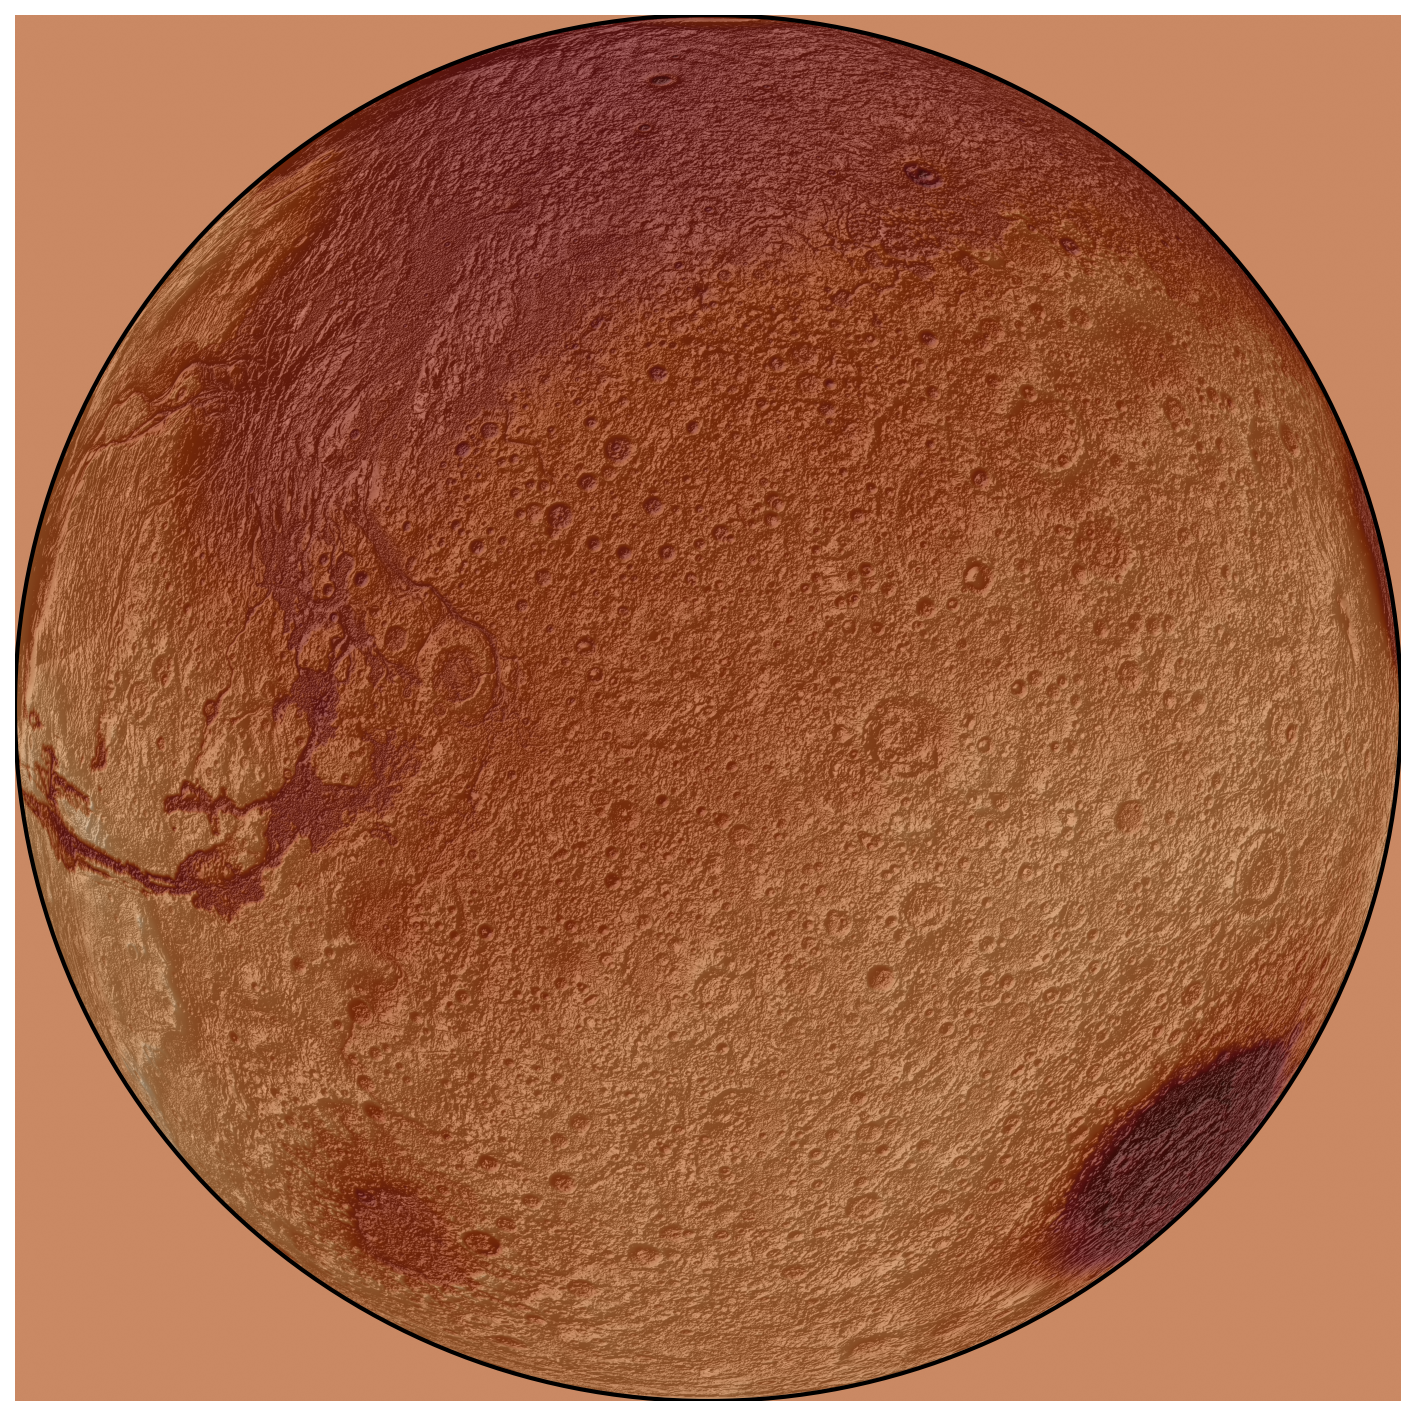

Saved: mars_ortho_clean_lon0_lat0.png


In [67]:
# View center
center_lon = 0   # Change to 90, 180, 270 for other views
center_lat = 0   # 0=equator, 90=north pole, -90=south pole

# Orthographic projection CRS
ortho_crs = CRS.from_proj4(
    f'+proj=ortho +lat_0={center_lat} +lon_0={center_lon} '
    f'+x_0=0 +y_0=0 +a={R} +b={R} +units=m +no_defs'
)

# -Output dimensions
out_width = out_height = 4000

# Output transform
out_transform = rasterio.transform.from_bounds(
    -R, -R, R, R, out_width, out_height
)

# Reproject DEM
dem_ortho = np.empty((out_height, out_width), dtype=dem_equirect.dtype)

reproject(
    source=dem_equirect,
    destination=dem_ortho,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=out_transform,
    dst_crs=ortho_crs,
    resampling=Resampling.bilinear
)

print("Mars DEM reprojected to orthographic")

# Hillshade
def hillshade(array, azimuth=315, altitude=45):
    x, y = np.gradient(array.astype(float))
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    az = np.radians(azimuth)
    alt = np.radians(altitude)
    hs = np.sin(alt) * np.sin(slope) + np.cos(alt) * np.cos(slope) * np.cos(az - aspect)
    return np.clip(hs, 0, 1)

hs = hillshade(dem_ortho)

# Mars-style colormap
mars_colors = ['#3d0c02', '#8b1a1a', '#c1440e', '#e07b39', '#f4a460', '#fddbb0']
mars_cmap = LinearSegmentedColormap.from_list("mars_cmap", mars_colors)

# Plot DEM with hillshade
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
extent = [-R, R, -R, R]

# DEM
ax.imshow(dem_ortho, extent=extent, cmap=mars_cmap, origin='upper', interpolation='bilinear')

# Hillshade overlay
ax.imshow(hs, extent=extent, cmap='gray', alpha=0.4, origin='upper')

# Globe edge
circle = Circle((0, 0), R, fill=False, edgecolor='black', linewidth=2, zorder=10)
ax.add_patch(circle)

# Remove axes, ticks, grid, title
ax.set_axis_off()

# Transparent background
fig.patch.set_alpha(0.0)
ax.set_facecolor('none')

# Save image
out_png = f'mars_ortho_clean_lon{center_lon}_lat{center_lat}.png'
plt.savefig(out_png, dpi=200, bbox_inches='tight', transparent=True)
plt.show()

print(f"Saved: {out_png}")

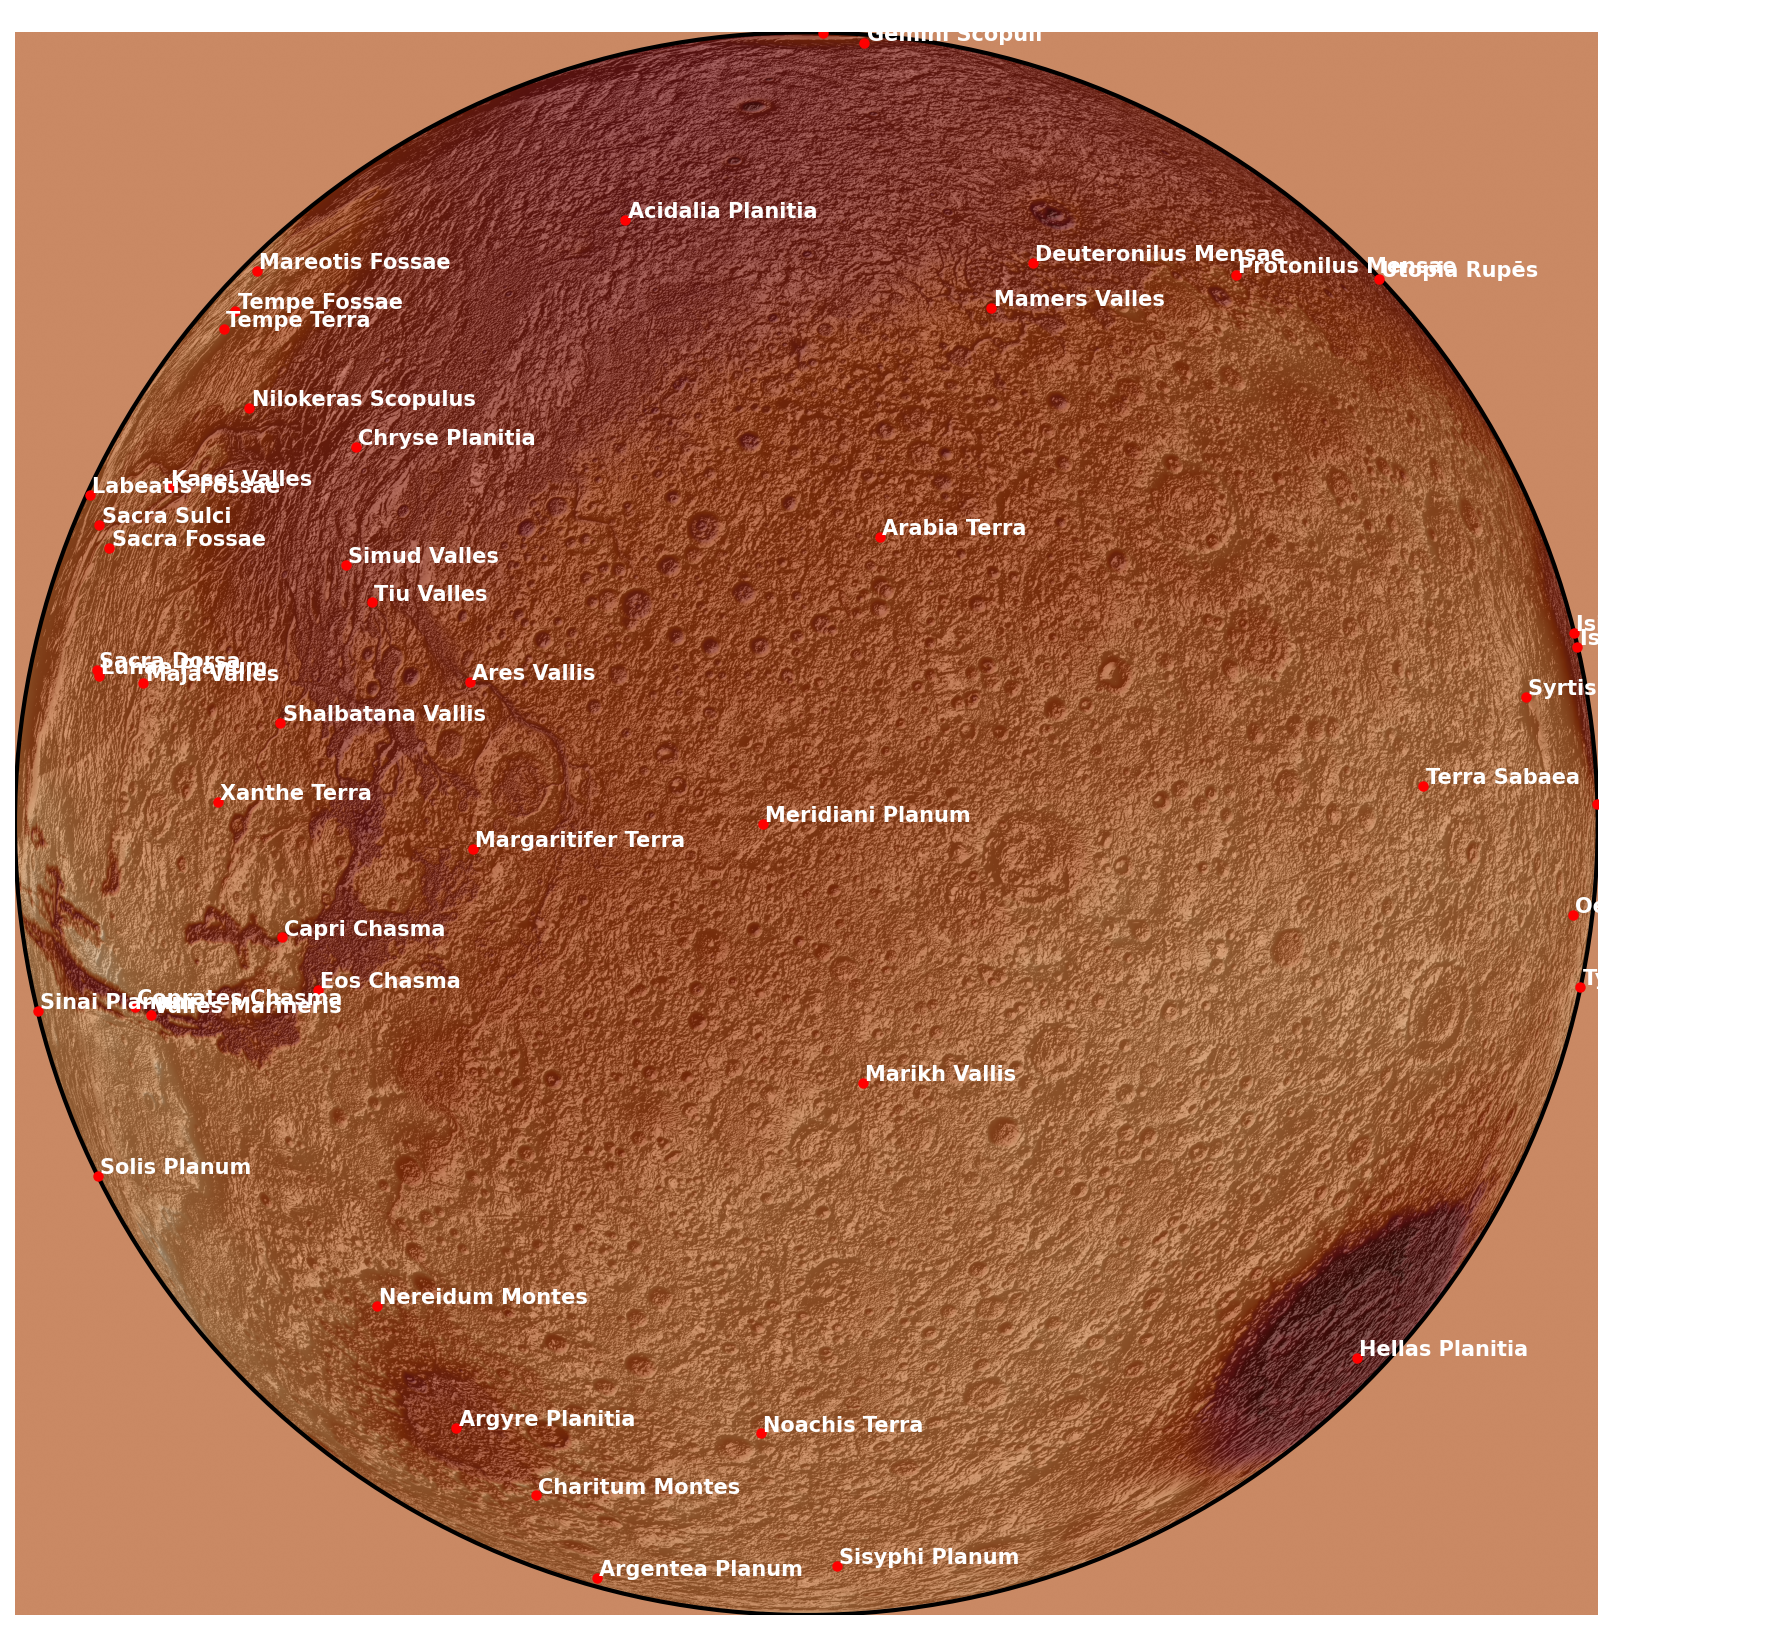

In [111]:
import pandas as pd
from pyproj import Proj, Transformer

# --- Load Mars features ---
features_df = pd.read_csv("MarsFeatures.csv")

# --- Sort and select top 30 by diameter ---
top_features = features_df.sort_values("Diameter", ascending=False).head(100)

# --- Mars orthographic projection centered at (0,0) ---
mars_proj = Proj(f"+proj=ortho +lat_0=0 +lon_0=0 +a={R} +b={R} +units=m +no_defs")
transformer = Transformer.from_proj("epsg:4326", mars_proj, always_xy=True)

# --- Convert lat/lon to x/y ---
top_features["x"], top_features["y"] = transformer.transform(
    top_features["Longitude_adjusted"].values,
    top_features["Center Latitude"].values
)

# --- Filter features within visible disk ---
top_features["distance"] = np.sqrt(top_features["x"]**2 + top_features["y"]**2)
visible_features = top_features[top_features["distance"] <= R]

# --- Plot overlay ---
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
extent = [-R, R, -R, R]


# DEM and hillshade
ax.imshow(dem_ortho, extent=extent, cmap=mars_cmap, origin='upper', interpolation='bilinear')
ax.imshow(hs, extent=extent, cmap='gray', alpha=0.4, origin='upper')

# Feature points and name labels
for _, row in visible_features.iterrows():
    ax.plot(row["x"], row["y"], 'ro', markersize=4, zorder=15)
    ax.text(row["x"] + 10000, row["y"] + 10000, row["Feature Name"], color='white',
            fontsize=10, weight='bold', zorder=16)



# Globe edge
circle = Circle((0, 0), R, fill=False, edgecolor='black', linewidth=2, zorder=10)
ax.add_patch(circle)

# Clean layout
ax.set_axis_off()
fig.patch.set_alpha(0.0)
ax.set_facecolor('none')

# Save
plt.tight_layout()
plt.savefig("mars_ortho_features_overlay.png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()


### Mercury
Seems to have some issues as the features do not seem completely aligned with the orthophoto

In [71]:
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

In [72]:
# Mercury mean radius in meters (from DEM spheroid)
R = 2439400

In [73]:
# Load DEM
dem_file = "Mercury_Messenger_USGS_DEM_Global_665m_v2.tif"
with rasterio.open(dem_file) as src:
    dem = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs
    
    print("DEM Info:")
    print(f"  CRS: {crs}")
    print(f"  Transform: {transform}")
    print(f"  Bounds: {bounds}")
    print(f"  Shape: {dem.shape}")

DEM Info:
  CRS: PROJCS["Equirectangular Mercury",GEOGCS["GCS_Mercury",DATUM["D_Mercury",SPHEROID["Mercury_localRadius",2439400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Transform: | 665.24, 0.00,-7663601.12|
| 0.00,-665.24, 3831800.56|
| 0.00, 0.00, 1.00|
  Bounds: BoundingBox(left=-7663601.1191669, bottom=-3831800.5595833994, right=7663601.119166899, top=3831800.5595835)
  Shape: (11520, 23040)


In [74]:
# Load CSV
csv_file = "MercuryFeatures.csv"
features = pd.read_csv(csv_file)

print(f"\nLoaded {len(features)} features")


Loaded 598 features


In [75]:
# Create source CRS (geographic Mercury coordinates)
# CSV format: planetocentric, degrees, 0-360 East
src_crs = (
    '+proj=longlat '
    '+a=2439400 '
    '+b=2439400 '
    '+no_defs'
)

# Create transformer from geographic to DEM's Equirectangular projection
transformer = Transformer.from_crs(src_crs, crs, always_xy=True)

# Transform coordinates
# CSV is 0-360, need to handle the coordinate system properly
lons = features['Center Longitude'].values
lats = features['Center Latitude'].values
features['x_m'], features['y_m'] = transformer.transform(lons, lats)

# Convert to pixel coordinates
def world_to_pixel(x, y, transform):
    """Convert world coordinates to pixel coordinates"""
    col, row = ~transform * (x, y)
    return int(col), int(row)

features['col'], features['row'] = zip(*features.apply(
    lambda r: world_to_pixel(r['x_m'], r['y_m'], transform), axis=1
))

# Check if points fall within valid pixel range
valid_mask = (
    (features['col'] >= 0) & (features['col'] < dem.shape[1]) &
    (features['row'] >= 0) & (features['row'] < dem.shape[0])
)
print(f"\nFeatures within DEM bounds: {valid_mask.sum()} / {len(features)}")


Features within DEM bounds: 598 / 598


In [76]:
# Export DEM as new TIFF
out_dem_tif = "Mercury_DEM_aligned.tif"
with rasterio.open(
    out_dem_tif,
    'w',
    driver='GTiff',
    height=dem.shape[0],
    width=dem.shape[1],
    count=1,
    dtype=dem.dtype,
    crs=crs,
    transform=transform,
    compress='lzw'
) as dst:
    dst.write(dem, 1)

print(f"\nDEM exported to {out_dem_tif}")


DEM exported to Mercury_DEM_aligned.tif


In [77]:
# Export features as GeoPackage
gdf = gpd.GeoDataFrame(
    features,
    geometry=[Point(xy) for xy in zip(features['x_m'], features['y_m'])],
    crs=crs
)

out_gpkg = "MercuryFeatures_aligned.gpkg"
gdf.to_file(out_gpkg, layer="features", driver="GPKG")
print(f"Features exported to {out_gpkg}")

Features exported to MercuryFeatures_aligned.gpkg
